In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import keras
import warnings
%matplotlib inline

In [2]:
from keras.models import Model,Sequential,load_model
from keras.layers import Conv2D,MaxPooling2D,Activation,BatchNormalization,Flatten,Dense,Dropout,Input,ZeroPadding2D,Add
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import glorot_uniform
from keras.applications.vgg16 import VGG16
from keras.applications import ResNet50
from keras.applications.inception_v3 import InceptionV3

In [3]:
image_gen = ImageDataGenerator(rotation_range=30, 
                               width_shift_range=0.1, 
                               height_shift_range=0.1,
                               rescale=1/255, 
                               shear_range=0.2, 
                               zoom_range=0.2, 
                               horizontal_flip=True, 
                               fill_mode='nearest' 
                              )

In [5]:
glacier=cv2.imread('seg_train/glacier/24.jpg')
glacier=cv2.cvtColor(glacier,cv2.COLOR_BGR2RGB)

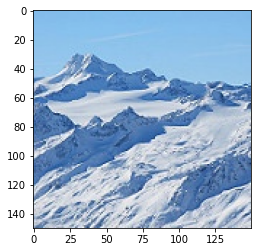

In [6]:
plt.imshow(glacier)

In [7]:
image_shape=glacier.shape

In [8]:
batch_size = 50

train_image_gen = image_gen.flow_from_directory('seg_train',
                                               target_size=image_shape[:2],
                                               batch_size=batch_size,
                                               class_mode='categorical')
test_image_gen = image_gen.flow_from_directory('seg_test',
                                               target_size=image_shape[:2],
                                               batch_size=batch_size,
                                               class_mode='categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [42]:
new_input=Input(shape=image_shape)

In [43]:
vgg_model=VGG16(weights="imagenet",include_top=False,input_tensor=new_input)

In [44]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [45]:
def identity_block(X, f, filters):
    
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X=Activation('relu')(X)
    
    X=Conv2D(filters=F2,kernel_size=(2,2),strides=(1,1),padding='same',kernel_initializer=glorot_uniform(seed=0))(X)
    X=Activation('relu')(X)
    
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    
    X = Add()([X_shortcut,X])
    X=Activation('relu')(X)
    
    return X

In [46]:
x=vgg_model.layers[9].output

x=Conv2D(filters=64,kernel_size=(3,3),strides=(2,2),padding='valid',kernel_initializer=glorot_uniform(seed=0))(x)

x=identity_block(x,2,[128,128,64])

x=MaxPooling2D((2,2),strides=(2,2))(x)

x=identity_block(x,2,[256,256,64])

x=MaxPooling2D((2,2),strides=(2,2))(x)

x=identity_block(x,2,[128,128,64])

x=Flatten()(x)

x=Dense(32)(x)
x=Activation('relu')(x)

x=Dense(6)(x)
x=Activation('softmax')(x)




In [ ]:
##Here the technique of transfer learning has been used.
##VGG16 model has been loaded with pre trained weights(ImageNet dataset).
##A new model has been created with initial layers(upto 9th layer) of the VGG16 model, followed by our newly defined identity blocks.
##Identity blocks are a feature of residual neural networks which is used to solve the vanishing gradient problem.
##Softmax activation layer is used to get the probabilities of 6 classes(sea,forest,glaciers,..etc)


In [47]:
model=Model(input=vgg_model.input,output=x,name="intel3")

C:\Users\Bhujith10\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="intel3", inputs=Tensor("in..., outputs=Tensor("ac...)`
  """Entry point for launching an IPython kernel.


In [48]:
model.summary()

Model: "intel3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 150, 150, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 150, 150, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 75, 75, 64)   0           block1_conv2[0][0]               
_____________________________________________________________________________________________

In [49]:
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [29]:
callbacks=[
    keras.callbacks.ModelCheckpoint(filepath='model2__bestweight.h5',save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',mode=max,factor=0.2,patience=5)
]


C:\Users\Bhujith10\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1019: RuntimeWarning: Learning Rate Plateau Reducing mode <built-in function max> is unknown, fallback to auto mode.
  RuntimeWarning)


In [ ]:
##callbacks
  ## The model with best weights is stored
  ## As we run the epochs if accuracy doesnt improve then learning rate is reduced by a factor of 0.2(After 5 epochs)

In [40]:
model.fit_generator(train_image_gen,epochs=20,steps_per_epoch=10,validation_data=test_image_gen,validation_steps=10,callbacks=callbacks)

Epoch 1/20
10/10 [==============================] - 154s 15s/step - loss: 0.6003 - accuracy: 0.7840 - val_loss: 0.5501 - val_accuracy: 0.8060
Epoch 2/20
10/10 [==============================] - 115s 12s/step - loss: 0.5472 - accuracy: 0.8340 - val_loss: 0.5306 - val_accuracy: 0.8100
Epoch 3/20
10/10 [==============================] - 115s 11s/step - loss: 0.6115 - accuracy: 0.7860 - val_loss: 0.6205 - val_accuracy: 0.8000
Epoch 4/20
10/10 [==============================] - 118s 12s/step - loss: 0.6224 - accuracy: 0.7680 - val_loss: 0.8115 - val_accuracy: 0.7680
Epoch 5/20
10/10 [==============================] - 150s 15s/step - loss: 0.6065 - accuracy: 0.7760 - val_loss: 0.8192 - val_accuracy: 0.7760
Epoch 6/20
10/10 [==============================] - 168s 17s/step - loss: 0.5566 - accuracy: 0.7980 - val_loss: 0.6997 - val_accuracy: 0.7940
Epoch 7/20
10/10 [==============================] - 172s 17s/step - loss: 0.5980 - accuracy: 0.8080 - val_loss: 0.5531 - val_accuracy: 0.8060
Epoch 

In [ ]:
##The model has been run for 20 epochs for 10 iterations which accounts for 200 epochs.
## After 1st iteration the model with best weights has been saved and that model has been loaded and run for the 2nd iteration and so on

In [41]:
from keras.preprocessing import image

file = 'seg_test/sea/20167.jpg'

img=cv2.imread(file)

#img=cv2.resize(img,(224,224))

img = np.expand_dims(img, axis=0)

img = img/255

In [42]:
img.shape

(1, 150, 150, 3)

In [48]:
predictions=model.predict(img).squeeze()

In [ ]:
##We test the model with image of the sea and it identifies correctly.

In [54]:
np.array(predictions).argmax()

4

In [55]:
train_image_gen.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [44]:
acc=model.evaluate(test_image_gen)

60/60 [==============================] - 161s 3s/step


In [45]:
acc_train=model.evaluate(train_image_gen)

281/281 [==============================] - 753s 3s/step


In [56]:
print('test loss'," ",acc[0])
print('test accuracy'," ",acc[1])

test loss   0.46495017409324646
test accuracy   0.812666654586792


In [47]:
print('training loss'," ",acc_train[0])
print('training accuracy'," ",acc_train[1])

training loss   0.5780181884765625
training accuracy   0.8101040124893188


In [14]:
model.save('intel_model2_2.h5')

In [ ]:
model=load_model('model2__bestweight.h5')